In [65]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [66]:
from fastai.structured import *
from fastai.column_data import *
import tensorflow as tf

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics


In [67]:
DATAPATH='/home/ubuntu/ShadowMimic/details1.csv'

In [74]:
data = pd.read_csv(DATAPATH, delimiter=",")

x = data["StartTime"].values
y = data["CPUAverage"].values

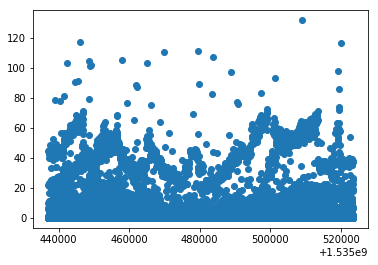

In [75]:
plt.scatter(x,y)
plt.show()

In [76]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [77]:
display_all(data.head())

,StartTime,ServiceName,AllocatedCPU,HealthyHosts,CPUAverage
0,1535516700,ServiceName1,1000,1,0.023284
1,1535519880,ServiceName1,1000,1,0.023468
2,1535523060,ServiceName1,1000,1,0.024140
3,1535474220,ServiceName1,1000,1,0.019813
4,1535477400,ServiceName1,1000,1,0.024553


In [78]:
display_all(data.tail())

,StartTime,ServiceName,AllocatedCPU,HealthyHosts,CPUAverage
38798,1535443200,ServiceName27,25,2,0.028192
38799,1535487720,ServiceName27,25,2,0.029508
38800,1535494080,ServiceName27,25,2,0.045539
38801,1535475000,ServiceName27,25,2,0.025074
38802,1535481360,ServiceName27,25,2,0.031373


In [79]:
display_all(data.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
StartTime,38803,NaN,NaN,NaN,1.53548e+09,24941.3,1.53544e+09,1.53546e+09,1.53548e+09,1.5355e+09,1.53552e+09
ServiceName,38803,27,ServiceName22,1440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AllocatedCPU,38803,NaN,NaN,NaN,875.759,762.877,25,250,500,1500,3000
HealthyHosts,38803,NaN,NaN,NaN,1.45254,0.808461,0,1,2,2,11
CPUAverage,38803,NaN,NaN,NaN,3.41144,9.97454,0,0.0198304,0.0634927,0.822495,131.792


In [44]:
#??RandomForestRegressor

In [45]:
##??data.to_feather

In [80]:
####temp####
#data = pd.read_csv(DATAPATH, delimiter=",")

#this is important
train_cats(data)

In [81]:
data.ServiceName.cat.categories

Index(['ServiceName1', 'ServiceName10', 'ServiceName11', 'ServiceName12',
       'ServiceName13', 'ServiceName14', 'ServiceName15', 'ServiceName16',
       'ServiceName17', 'ServiceName18', 'ServiceName19', 'ServiceName2',
       'ServiceName20', 'ServiceName21', 'ServiceName22', 'ServiceName23',
       'ServiceName24', 'ServiceName25', 'ServiceName26', 'ServiceName27',
       'ServiceName3', 'ServiceName4', 'ServiceName5', 'ServiceName6',
       'ServiceName7', 'ServiceName8', 'ServiceName9'],
      dtype='object')

In [82]:
print(data.isnull().sum())

StartTime       0
ServiceName     0
AllocatedCPU    0
HealthyHosts    0
CPUAverage      0
dtype: int64


In [83]:
#??os
#??proc_df  
#display_all(data.isnull().sum().sort_index()/len(data))

In [84]:
os.makedirs('tmp', exist_ok=True)
data.to_feather('tmp/sams')

In [85]:
#??proc_df
#shouldnt need to do this, but bah
data = pd.read_feather('tmp/sams')
#display_all(data)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [86]:
df, y, nas = proc_df(data, 'CPUAverage')

In [87]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df,y)
m.score(df,y)

df.columns

Index(['StartTime', 'ServiceName', 'AllocatedCPU', 'HealthyHosts'], dtype='object')

In [88]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

#training sset
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(data, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((26803, 4), (26803,), (12000, 4))

In [89]:
#def rmse(x,y): return math.sqrt(((x-y)**2).mean())

#def print_score(m):
#    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
#                m.score(X_train, y_train), m.score(X_valid, y_valid)]
#    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
#    print(res)
    
def print_score(m):
    res = [m.predict(X_train), m.predict(X_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [90]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 460 ms, sys: 0 ns, total: 460 ms
Wall time: 210 ms
[array([1.39432, 0.02671, 0.05957, 0.02169, 0.02454, 0.02256, 0.02631, 0.09395, 0.01939, 0.02422, 0.02543,
       0.02392, 0.02217, 0.0225 , 0.02292, 0.02281, 0.02468, 0.02468, 0.0234 , 0.02172, ..., 0.03991,
       0.02594, 0.03612, 0.03997, 0.02694, 0.05304, 0.10004, 0.10004, 0.05261, 0.04175, 0.05319, 0.10305,
       0.02979, 0.0665 , 0.57159, 0.03799, 0.08422, 0.08578, 0.02658, 0.03317]), array([0.05106, 0.049  , 0.04798, 0.02491, 0.03722, 0.03258, 0.13731, 0.03833, 0.288  , 0.02419, 0.03804,
       0.03156, 0.04349, 0.02202, 0.04355, 0.05933, 0.04855, 0.03041, 0.02117, 0.03903, ..., 0.07101,
       0.05073, 0.05361, 0.072  , 0.06395, 0.05049, 0.05472, 0.05063, 0.052  , 0.11689, 0.04963, 0.04917,
       0.05765, 0.05232, 0.05371, 0.05935, 0.05445, 0.12606, 0.05172, 0.05304]), 0.9476578081180006, -0.11169857433757047]


In [91]:
#take random samples
df_trn, y_trn, nas = proc_df(data, 'CPUAverage', subset=30000, na_dict=nas)

X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [92]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 344 ms, sys: 0 ns, total: 344 ms
Wall time: 110 ms
[array([0.02643, 0.02268, 0.02464, 0.02728, 0.12179, 0.0237 , 0.02439, 0.02349, 0.02331, 0.02304, 0.02467,
       0.02033, 0.02248, 0.04636, 0.02315, 0.02362, 0.02257, 0.02308, 0.02152, 0.0224 , ..., 2.53979,
       0.81619, 1.62568, 0.67158, 1.52452, 1.19819, 1.28915, 1.26423, 1.93076, 1.38106, 1.80783, 1.8918 ,
       1.46741, 0.89524, 1.47809, 1.8912 , 1.36724, 1.79161, 0.83613, 1.4282 ]), array([0.00467, 0.00572, 0.00619, 0.0054 , 0.00617, 0.00638, 0.00633, 0.00464, 0.00434, 0.00493, 0.00643,
       0.00487, 0.00498, 0.005  , 0.0058 , 0.00597, 0.00491, 0.0057 , 0.00541, 0.00652, ..., 0.07537,
       0.06605, 0.07286, 0.08495, 0.06724, 0.06719, 0.09276, 0.0641 , 0.07125, 0.08338, 0.06503, 0.06308,
       0.07675, 0.0676 , 0.07067, 0.08447, 0.0711 , 0.13737, 0.07058, 0.07003]), 0.9503221027282116, -0.14469601330921744]


In [93]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[array([0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 ,
       0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , ..., 0.46504,
       0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504,
       0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504]), array([0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 ,
       0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , 0.0292 , ..., 0.46504,
       0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504,
       0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504, 0.46504]), 0.7164799791154575, -0.05936028190619069]


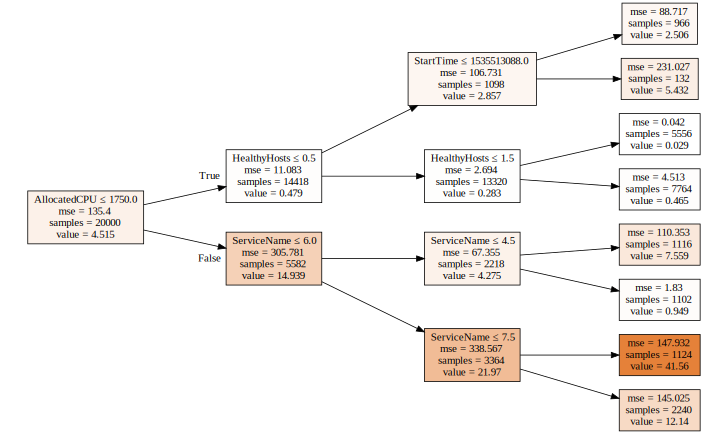

In [94]:
draw_tree(m.estimators_[0], df_trn, precision=3) 

In [95]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[array([0.02695, 0.02172, 0.02467, 0.02717, 0.02109, 0.02414, 0.02457, 0.02401, 0.02293, 0.02372, 0.02463,
       0.01941, 0.02276, 0.02378, 0.02349, 0.02352, 0.02245, 0.02277, 0.02158, 0.02287, ..., 2.68052,
       0.62459, 1.562  , 0.69804, 1.5326 , 1.03744, 1.09714, 1.1261 , 1.72896, 1.48019, 1.84193, 1.91674,
       1.19814, 0.86261, 1.39138, 1.55226, 1.41041, 1.7812 , 0.84498, 1.47392]), array([0.00463, 0.00568, 0.00643, 0.00574, 0.00606, 0.00788, 0.00662, 0.00466, 0.00436, 0.00491, 0.00641,
       0.00487, 0.00508, 0.00469, 0.006  , 0.00622, 0.00493, 0.00608, 0.00546, 0.00614, ..., 0.12235,
       0.11267, 0.11783, 0.16303, 0.11263, 0.1093 , 0.11642, 0.11184, 0.11728, 0.12924, 0.10831, 0.10846,
       0.12028, 0.12076, 0.12212, 0.11908, 0.12211, 0.11968, 0.12388, 0.12348]), 0.962404319712215, -0.769307521744359]


In [96]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0.00463]), 0.004629362, 0.07064106120000001)

In [97]:
preds.shape

(1, 12000)

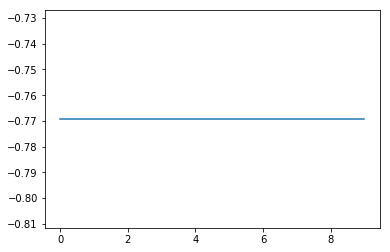

In [98]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);